In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
import torch

In [0]:
path = untar_data(URLs.MNIST)

In [0]:
images = ImageList.from_folder(path, convert_mode='L').split_by_folder(train='training', valid='testing').label_from_folder()

In [5]:
images

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
bs = 128
data = images.databunch(bs=bs).normalize()

In [7]:
data

ImageDataBunch;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
6,6,6,6,6
Path: /root/.fastai/data/mnist_png;

Test: None

6


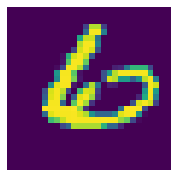

In [8]:
x,y = data.train_ds[0]
x.show()
print(y)

In [18]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## Our CNN

In [0]:
def conv3x3(in_planes, out_planes, stride=2, padding=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=padding, bias=False)

In [0]:
mi_conv = nn.Sequential(
    conv3x3(1, 8), # Forma (8, 14, 14)
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv3x3(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv3x3(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv3x3(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv3x3(16, 10), # 1 Forma (10, 1, 1)
    nn.BatchNorm2d(10),
    Flatten()     # Quitar el (1,1) 
)

In [0]:
learn = Learner(data, mi_conv, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [22]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,608      True      
___________________________________________________

In [0]:
xb = xb.cuda()

In [25]:
mi_conv(xb).shape

torch.Size([128, 10])

In [13]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.130372,0.139557,0.953700,00:27
1,0.084520,0.053534,0.983700,00:26
2,0.045928,0.034867,0.988400,00:26


conv_layer ya tiene la secuencia de conv + batch norm + relu

In [0]:
mi_conv_2 = nn.Sequential(
    conv3x3(1, 8),   # 14
    conv3x3(8, 16),  # 7
    conv3x3(16, 32), # 4
    conv3x3(32, 16), # 2
    conv3x3(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, mi_conv_2, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [30]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.683619,0.427389,0.893400,00:24


## Resnet

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
mi_resnet = nn.Sequential(
    conv3x3(1, 8),
    ResBlock(8),
    conv3x3(8, 16),
    ResBlock(16),
    conv3x3(16, 32),
    ResBlock(32),
    conv3x3(32, 16),
    ResBlock(16),
    conv3x3(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, mi_resnet, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [38]:
learn.fit_one_cycle(1, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.769038,0.353609,0.963600,00:30
